In [1]:
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any

# Azure OpenAI
from openai import AzureOpenAI as AzureOpenAIService

from bert_score import score

/home/Projects/prompt_test/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Hardcoded configuration
application_settings = {
    "azure_openai_service": {
        "service_access_key": "YOUR_AZURE_OPENAI_API_KEY",  # Replace with your actual API key
        "service_api_version": "2024-03-01-preview", # Adjusted to a common preview version
        "service_endpoint_url": "YOUR_AZURE_OPENAI_ENDPOINT",  # Replace with your endpoint
        "service_deployment_id": "gpt-4o",  # Replace with your deployment name
        "service_model_identifier": "gpt-4o",
    },
    "bert": {"model_name": "bert-base-uncased", "similarity_threshold": 0.7},
    "benchmarking_parameters": {
        "number_of_prompt_suggestions": 3,
        "assessment_metrics_list": [
            "semantic_similarity_score",
            "generated_response_length",
            "api_token_consumption",
        ],
    },
    "data_output_folder": "benchmark_results",
}

# Initialize containers for script data
generated_prompt_alternatives = []
benchmark_assessment_outcomes = {}

In [3]:
# Set up Azure OpenAI client
try:
    azure_ai_client_instance = AzureOpenAIService(
        api_key=application_settings["azure_openai_service"]["service_access_key"],
        api_version=application_settings["azure_openai_service"]["service_api_version"],
        azure_endpoint=application_settings["azure_openai_service"]["service_endpoint_url"],
    )
    print("Azure OpenAI client initialized successfully.")
except Exception as error_detail:
    print(f"Failed to initialize Azure OpenAI client: {error_detail}")
    raise

Azure OpenAI client initialized successfully.


In [4]:
# Generate prompts for a specific task
main_task_objective: str = "Describe the key benefits of using solar power for residential energy needs. Format as a bulleted list."

# Define the golden answer - this is what we want all responses to be similar to
# This is an example. Replace with your actual golden answer relevant to your task_description.
standard_reference_output: str = """Generative AI refers to a class of artificial intelligence models designed to create new content, such as text, images, or music, by learning patterns from existing data."""

print(f"Task Description loaded: {main_task_objective[:100]}...")
print(f"Golden Answer set: {standard_reference_output[:100]}...")

Task Description loaded: Describe the key benefits of using solar power for residential energy needs. Format as a bulleted li...
Golden Answer set: Generative AI refers to a class of artificial intelligence models designed to create new content, su...


In [5]:
# Generate prompt candidates using Azure OpenAI
num_prompt_suggestions = application_settings["benchmarking_parameters"]["number_of_prompt_suggestions"]
print(f"Generating {num_prompt_suggestions} prompt candidates for task: {main_task_objective[:10]}...")

prompt_generation_system_message = f"""
Act as an expert prompt engineer tasked with generating {num_prompt_suggestions} diverse and effective prompt variations for achieving a goal.
Follow these instructions strictly for each prompt generated:
1.  Goal Clarity: Ensure the prompt's objective is unmistakable.
2.  Format Specification: Embed clear instructions within the prompt about the desired output structure.
3.  Methodological Diversity: Make each prompt unique in its approach (consider: direct instruction, role-play, question-based, constraint-driven, comparative).
4.  Completeness: Provide necessary context within the prompt for task execution.

Formatting Requirements for Your Response:
1. Prefix each prompt with `PROMPT #` followed by its number (e.g., `PROMPT #1`).
2. Deliver *only* the raw prompts, without any surrounding text or commentary.
3. Strict Formatting: Present the output as follows:
    `PROMPT #1`
    [Prompt text]
    `---`
    `PROMPT #2`
    [Prompt text]
    `---`
    ...and so on.
4. Content Constraint: Your entire response should consist *solely* of the numbered prompts separated by '---'. No extra text.
"""

try:
    prompt_generation_api_response = azure_ai_client_instance.chat.completions.create(
        model=application_settings["azure_openai_service"]["service_deployment_id"],
        messages=[
            {"role": "system", "content": prompt_generation_system_message},
            {
                "role": "user",
                "content": f"Your task is to generate strictly {num_prompt_suggestions} high-quality, distinct prompt candidates for the following objective: {main_task_objective}",
            },
        ],
        temperature=0.7,
        max_tokens=2000,
    )

    response_content_text = prompt_generation_api_response.choices[0].message.content
    
    generated_prompt_alternatives = []
    # Parse the response to extract individual prompts
    # Assuming the model strictly follows the "---" separator instruction
    raw_prompts = response_content_text.split("---")
    
    for R_prompt_block in raw_prompts:
        R_prompt_block_cleaned = R_prompt_block.strip()
        if R_prompt_block_cleaned:
            # Remove "PROMPT #X" prefix if present
            if R_prompt_block_cleaned.startswith("PROMPT #"):
                actual_prompt_content = R_prompt_block_cleaned.split("\n", 1)[-1].strip()
            else:
                actual_prompt_content = R_prompt_block_cleaned
            generated_prompt_alternatives.append(actual_prompt_content)

    print(f"Extracted {len(generated_prompt_alternatives)} prompt candidates")
    for idx, single_prompt_text in enumerate(generated_prompt_alternatives):
        print(f"Prompt Candidate #{idx+1}: {single_prompt_text[:70]}..." if len(single_prompt_text) > 70 else single_prompt_text)

except Exception as error_detail:
    print(f"Failed to generate prompt candidates: {error_detail}")
    generated_prompt_alternatives = [] # Ensure it's empty on failure
    print("Failed to generate prompt candidates.")

Generating 3 prompt candidates for task: Describe t...
Extracted 3 prompt candidates
Prompt Candidate #1: `PROMPT #1`  
Explain the key benefits of using solar power for reside...
Prompt Candidate #2: `PROMPT #2`  
Imagine you are an expert in sustainable energy solution...
Prompt Candidate #3: `PROMPT #3`  
What are the primary advantages of adopting solar power ...


In [6]:
def get_bert_score(predictions, references):
    P, R, F1 = score(predictions, references, lang="en", verbose=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

In [7]:
def evaluate_single_prompt(prompt_text_to_test: str, reference_output_text: str = None) -> Dict[str, Any]:
    test_initiation_time = time.time()
    actual_model_response_content = "Error: Response not generated" # Default in case of failure before API call
    
    messages_for_api = [{"role": "user", "content": []}]
    messages_for_api[0]["content"].append({"type": "text", "text": prompt_text_to_test})

    try:
        api_response_object = azure_ai_client_instance.chat.completions.create(
            model=application_settings["azure_openai_service"]["service_deployment_id"],
            messages=messages_for_api,
            temperature=0.1,  # Low temperature for more deterministic results
            max_tokens=1000,
        )

        actual_model_response_content = api_response_object.choices[0].message.content
        time_to_get_response = time.time() - test_initiation_time
        tokens_consumed_by_api = api_response_object.usage.total_tokens

        evaluation_result_data = {
            "tested_prompt_text": prompt_text_to_test,
            "llm_generated_output": actual_model_response_content,
            "response_time_seconds": time_to_get_response,
            "api_tokens_used": tokens_consumed_by_api,
            "output_char_length": len(actual_model_response_content),
        }

        if reference_output_text:
            bert_p, bert_r, bert_f1 = get_bert_score([actual_model_response_content], [reference_output_text])
            print(bert_p, bert_r, bert_f1)
            evaluation_result_data["bert_precision"] = bert_p
            evaluation_result_data["bert_recall"] = bert_r
            evaluation_result_data["reference_text_provided"] = reference_output_text
            evaluation_result_data["semantic_similarity"] = bert_f1
            evaluation_result_data["success"] = (
                bert_f1 >= application_settings["bert"]["similarity_threshold"]
            )
        return evaluation_result_data

    except Exception as e:
        print(f"Error testing prompt '{prompt_text_to_test[:50]}...': {e}")

In [8]:
# Run benchmarks on all prompt candidates against the test inputs.
from tqdm import tqdm

if not generated_prompt_alternatives:
    print("No prompt candidates available for benchmarking")
else:        
    benchmark_results = {}

    for i, prompt in enumerate(generated_prompt_alternatives):
        prompt_id = f"prompt_{i+1}"
        print(f"Benchmarking {prompt_id}...")

        results = []
        for test_case in tqdm(generated_prompt_alternatives, desc=f"Testing {prompt_id}"):
            result = evaluate_single_prompt(prompt, standard_reference_output)
            results.append(result)

        # Calculate aggregate metrics
        metrics = {
            "avg_latency": float(np.mean([r["response_time_seconds"] for r in results])),
            "avg_token_usage": float(np.mean([r["api_tokens_used"] for r in results])),
            "avg_response_length": float(
                np.mean([r["output_char_length"] for r in results])
            ),
        }

        # Add semantic similarity metrics if expected outputs were provided
        if all("semantic_similarity" in r for r in results):
            metrics["avg_semantic_similarity"] = float(
                np.mean([r["semantic_similarity"] for r in results])
            )
            metrics["avg_success_rate"] = float(
                np.mean([r["success"] for r in results])
            )

        benchmark_results[prompt_id] = {
            "prompt_text": prompt,
            "results": results,
            "metrics": metrics,
        }

        print(f"Completed benchmarking {prompt_id}")

Benchmarking prompt_1...


Testing prompt_1:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


computing greedy matching.


Testing prompt_1:  33%|███▎      | 1/3 [00:10<00:20, 10.25s/it]

done in 2.45 seconds, 0.41 sentences/sec
0.7692768573760986 0.8225100040435791 0.795003354549408


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


computing greedy matching.


Testing prompt_1:  67%|██████▋   | 2/3 [00:17<00:08,  8.38s/it]

done in 2.34 seconds, 0.43 sentences/sec
0.7708181142807007 0.8200051784515381 0.794651210308075


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


computing greedy matching.


Testing prompt_1: 100%|██████████| 3/3 [00:25<00:00,  8.45s/it]


done in 2.13 seconds, 0.47 sentences/sec
0.7706917524337769 0.8209688663482666 0.7950361967086792
Completed benchmarking prompt_1
Benchmarking prompt_2...


Testing prompt_2:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


computing greedy matching.


Testing prompt_2:  33%|███▎      | 1/3 [00:08<00:16,  8.12s/it]

done in 2.82 seconds, 0.35 sentences/sec
0.7655795812606812 0.8171724677085876 0.7905351519584656


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


computing greedy matching.


Testing prompt_2:  67%|██████▋   | 2/3 [00:15<00:07,  7.87s/it]

done in 2.26 seconds, 0.44 sentences/sec
0.7674957513809204 0.8123618364334106 0.7892917394638062


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


computing greedy matching.


Testing prompt_2: 100%|██████████| 3/3 [00:23<00:00,  7.70s/it]


done in 2.47 seconds, 0.40 sentences/sec
0.7631464600563049 0.8098708987236023 0.7858147025108337
Completed benchmarking prompt_2
Benchmarking prompt_3...


Testing prompt_3:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


computing greedy matching.


Testing prompt_3:  33%|███▎      | 1/3 [00:04<00:09,  4.92s/it]

done in 1.57 seconds, 0.64 sentences/sec
0.7788435816764832 0.8168872594833374 0.7974119186401367


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


computing greedy matching.


Testing prompt_3:  67%|██████▋   | 2/3 [00:11<00:05,  5.77s/it]

done in 1.89 seconds, 0.53 sentences/sec
0.7755596041679382 0.8205028176307678 0.7973984479904175


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


computing greedy matching.


Testing prompt_3: 100%|██████████| 3/3 [00:16<00:00,  5.60s/it]

done in 2.00 seconds, 0.50 sentences/sec
0.7785924673080444 0.8132737278938293 0.7955552935600281
Completed benchmarking prompt_3


In [9]:
# Print summary of benchmark results
print("\nBenchmark Results Summary:")
if not benchmark_results:
    print("No benchmark data to display.")
for prompt_label, data_item in benchmark_results.items():
    perf_metrics = data_item["metrics"]
    print(f"\n{prompt_label}:")
    print(f"  Avg Response Time: {perf_metrics.get('avg_latency', 0):.2f}s")
    print(f"  Avg Token Usuage: {perf_metrics.get('avg_token_usage', 0):.2f}s")
    print(f"  Avg Tokens Consumed: {perf_metrics.get('avg_response_length', 0):.1f}")
    if "avg_semantic_similarity" in perf_metrics:
        print(f"  Avg Semantic Similarity: {perf_metrics['avg_semantic_similarity']:.4f}")
        print(f"  Success Percentage: {perf_metrics['avg_success_rate']:.2%}")


Benchmark Results Summary:

prompt_1:
  Avg Response Time: 5.09s
  Avg Token Usuage: 444.00s
  Avg Tokens Consumed: 2191.0
  Avg Semantic Similarity: 0.7949
  Success Percentage: 100.00%

prompt_2:
  Avg Response Time: 4.68s
  Avg Token Usuage: 507.33s
  Avg Tokens Consumed: 2296.7
  Avg Semantic Similarity: 0.7885
  Success Percentage: 100.00%

prompt_3:
  Avg Response Time: 3.30s
  Avg Token Usuage: 371.00s
  Avg Tokens Consumed: 1773.3
  Avg Semantic Similarity: 0.7968
  Success Percentage: 100.00%


In [10]:
scores = {}
for prompt_id, data in benchmark_results.items():
    metrics = data["metrics"]
    score = 0
    print(metrics)

    # If semantic similarity metrics are available
    if "avg_semantic_similarity" in metrics:
        score += 0.6 * metrics["avg_semantic_similarity"]
        score += 0.3 * metrics["avg_success_rate"]

    # Always consider efficiency metrics (lower is better)
    max_latency = max(
        [r["metrics"]["avg_latency"] for r in benchmark_results.values()]
    )
    max_tokens = max(
        [r["metrics"]["avg_token_usage"] for r in benchmark_results.values()]
    )

    norm_latency = (
        metrics["avg_latency"] / max_latency if max_latency > 0 else 0
    )
    norm_tokens = (
        metrics["avg_token_usage"] / max_tokens if max_tokens > 0 else 0
    )

    # Lower values are better for these metrics, so we subtract
    score -= 0.05 * norm_latency
    score -= 0.05 * norm_tokens

    scores[prompt_id] = score

# Find the prompt with the highest score
best_prompt_id = max(scores, key=scores.get)
best_prompt_data = benchmark_results[best_prompt_id]

print(
    f"Best prompt selected: {best_prompt_id} with score {scores[best_prompt_id]:.4f}"
)
# print(best_prompt_data['model_output'])
best_performing_prompt_data  = {
    "prompt_id": best_prompt_id,
    "prompt_text": best_prompt_data["prompt_text"],
    "score": scores[best_prompt_id],
    "metrics": best_prompt_data["metrics"],
}

{'avg_latency': 5.085126082102458, 'avg_token_usage': 444.0, 'avg_response_length': 2191.0, 'avg_semantic_similarity': 0.7948969205220541, 'avg_success_rate': 1.0}
{'avg_latency': 4.682161966959636, 'avg_token_usage': 507.3333333333333, 'avg_response_length': 2296.6666666666665, 'avg_semantic_similarity': 0.7885471979777018, 'avg_success_rate': 1.0}
{'avg_latency': 3.3038899103800454, 'avg_token_usage': 371.0, 'avg_response_length': 1773.3333333333333, 'avg_semantic_similarity': 0.7967885533968607, 'avg_success_rate': 1.0}
Best prompt selected: prompt_3 with score 0.7090


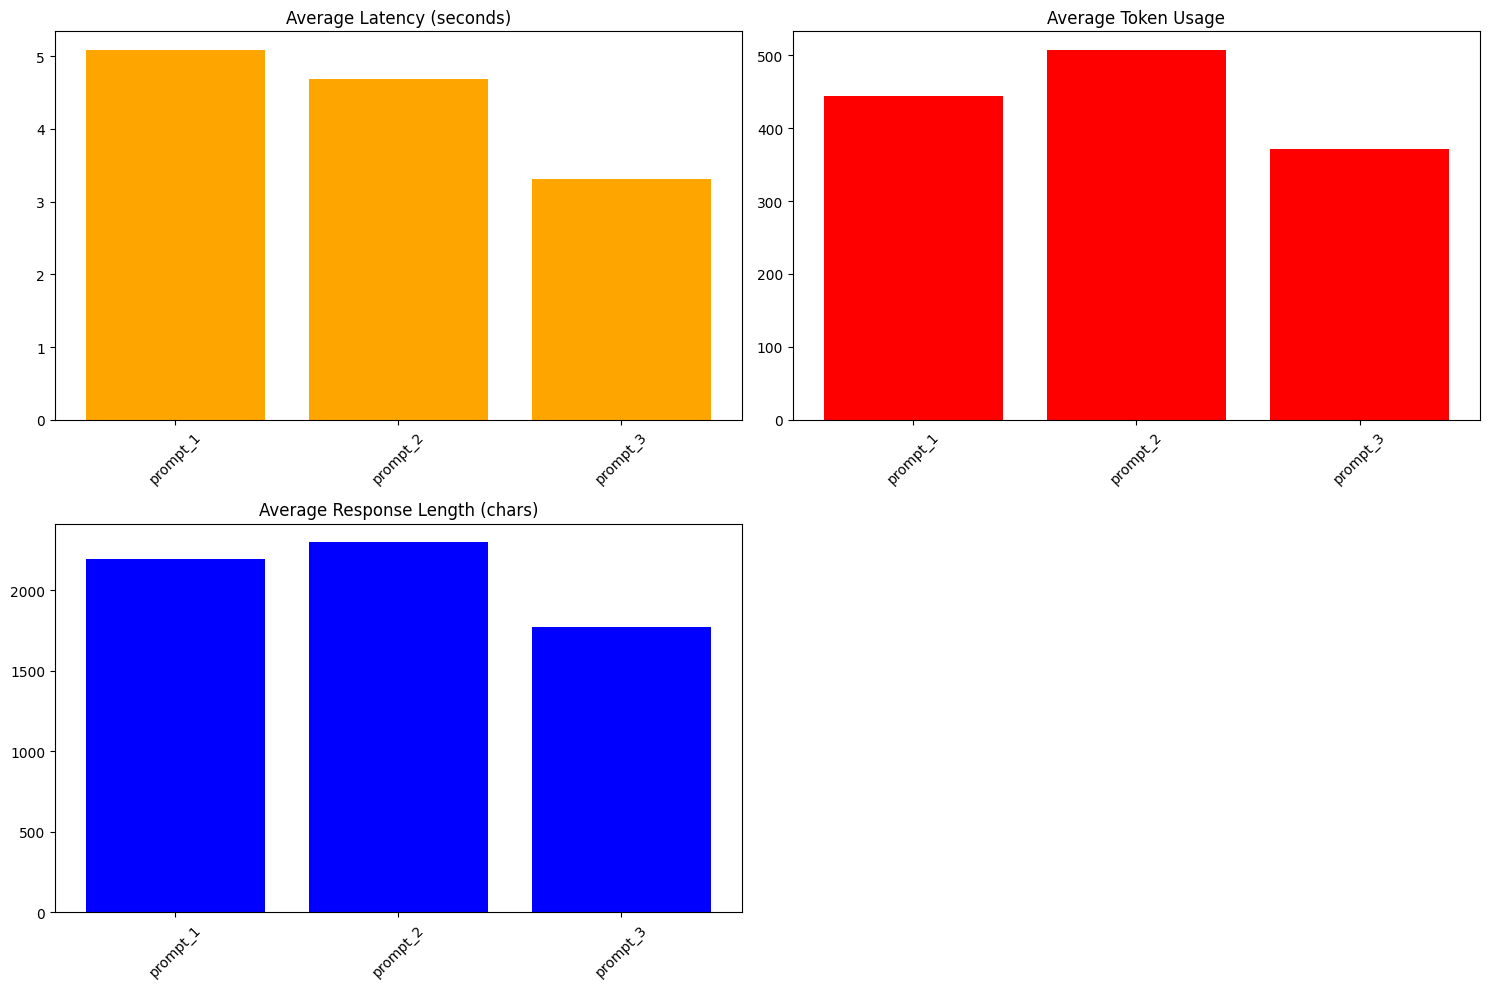

In [11]:
# Extract metrics for visualization
prompt_ids = list(benchmark_results.keys())
latencies = [r["metrics"]["avg_latency"] for r in benchmark_results.values()]
token_usages = [r["metrics"]["avg_token_usage"] for r in benchmark_results.values()]
response_lengths = [
    r["metrics"]["avg_response_length"] for r in benchmark_results.values()
]
# Create bar charts
plt.figure(figsize=(15, 10))

# Latency chart
plt.subplot(2, 2, 1)
plt.bar(prompt_ids, latencies, color="orange")
plt.title("Average Latency (seconds)")
plt.xticks(rotation=45)

# Token usage chart
plt.subplot(2, 2, 2)
plt.bar(prompt_ids, token_usages, color="red")
plt.title("Average Token Usage")
plt.xticks(rotation=45)

# Response length chart
plt.subplot(2, 2, 3)
plt.bar(prompt_ids, response_lengths, color="blue")
plt.title("Average Response Length (chars)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

        

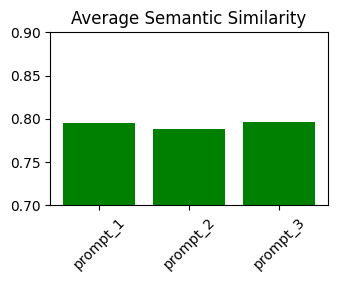

In [20]:
# Add semantic similarity chart if available
if all(
    "avg_semantic_similarity" in benchmark_results[pid]["metrics"]
    for pid in prompt_ids
):
    similarities = [
        r["metrics"]["avg_semantic_similarity"] for r in benchmark_results.values()
    ]
    success_rates = [
        r["metrics"]["avg_success_rate"] for r in benchmark_results.values()
    ]
plt.subplot(2, 2, 4)
plt.bar(prompt_ids, similarities, color="green")
plt.title("Average Semantic Similarity")
plt.ylim(0.7, 0.9)
plt.xticks(rotation=45)

# Add a second subplot for success rates
# plt.figure(figsize=(8, 6))
# plt.bar(prompt_ids, success_rates, color="purple")
# plt.title("Success Rate")
# plt.ylim(0, 1)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()